## Question 1

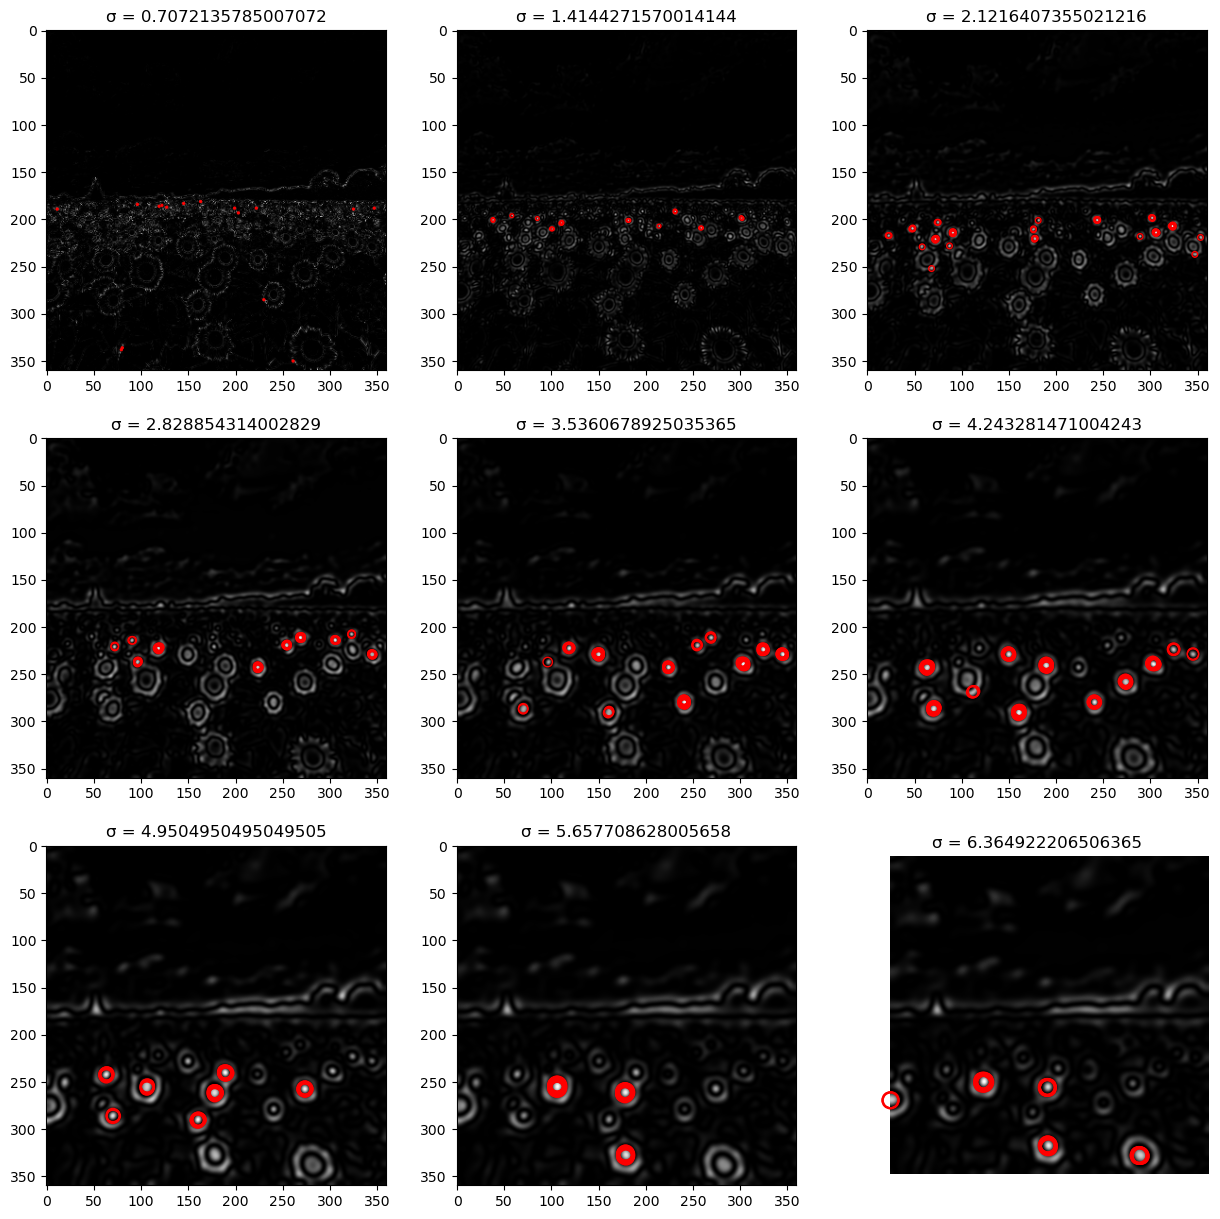

In [137]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import cv2 as cv

%matplotlib inline

# Load the image
im = cv.imread('Images/the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)

# Convert the image to grayscale
im_gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY) / 255

# Define the Laplace of Gaussian (LoG) filter
def LoG(sigma):
    hw = round(3 * sigma)    
    X, Y = np.meshgrid(np.arange(-hw, hw + 1, 1), np.arange(-hw, hw + 1, 1))
    log_filter = ((X**2 + Y**2)/(2*sigma**2) - 1) * np.exp(-(X**2 + Y**2)/(2*sigma**2)) / (np.pi * sigma**4)
    return log_filter

# Function to find local maxima in the filtered image
def detect_max(img_log, sigma):
    coordinates = []
    (h, w) = img_log.shape
    k = 1
    for i in range(k, h-k):
        for j in range(k, w-k):
            slice_img = img_log[i-k:i+k+1, j-k:j+k+1]
            result = np.max(slice_img)  # finding maximum
            if result >= 0.09:  # threshold
                x, y = np.unravel_index(slice_img.argmax(), slice_img.shape)
                coordinates.append((i+x-k, j+y-k))  # finding coordinates
    return set(coordinates)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for r, ax in enumerate(axes.flatten(), start=1):
    sigma = r / 1.414 #1.414 = sqrt(2)
    LOG = sigma**2 * LoG(sigma)
    img1_log = np.square(cv.filter2D(im_gray, -1, LOG))

    coordinates = detect_max(img1_log, sigma)

    ax.imshow(img1_log, cmap='gray')
    ax.set_title(f'\u03C3 = {sigma}')

    for x, y in coordinates:
        c = Circle((y, x), sigma * 1.414, color='red', linewidth=1, fill=False)
        ax.add_patch(c)
    ax.plot()

plt.axis('off')
plt.show()

## Question 2

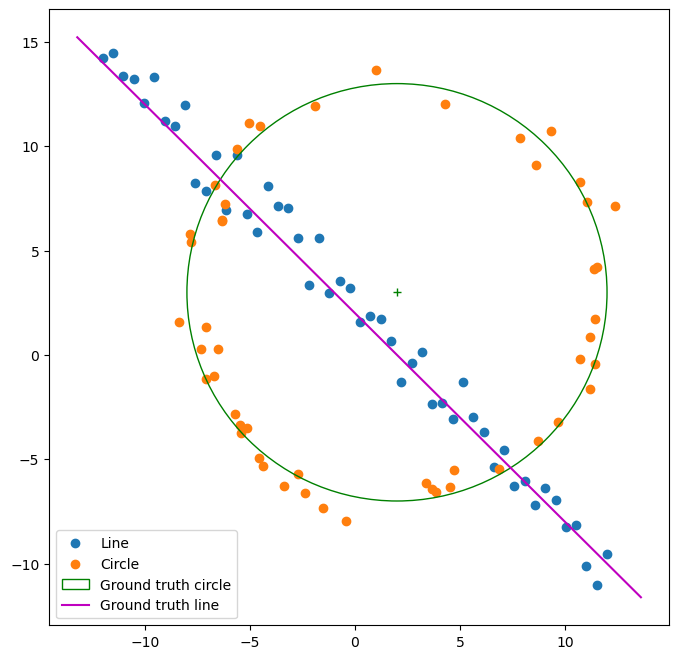

In [138]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

# Generate points for a circle
def generate_circle_points(center, radius, num_points):
    theta = np.random.uniform(0, 2 * np.pi, num_points)
    noise = np.random.normal(0, radius / 16, num_points)
    x = center[0] + (radius + noise) * np.cos(theta)
    y = center[1] + (radius + noise) * np.sin(theta)
    return np.column_stack((x, y))

# Generate points for a line
def generate_line_points(slope, intercept, num_points):
    x = np.linspace(-12, 12, num_points)
    noise = np.random.normal(0, 1, num_points)
    y = slope * x + intercept + noise
    return np.column_stack((x, y))

# Ground truth parameters
circle_center = (2, 3)
circle_radius = 10
line_slope = -1
line_intercept = 2

# Generate points
num_points = 100
half_num_points = num_points // 2

circle_points = generate_circle_points(circle_center, circle_radius, half_num_points)
line_points = generate_line_points(line_slope, line_intercept, half_num_points)

# Combine points
X = np.vstack((circle_points, line_points))

# Plot the points
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(line_points[:, 0], line_points[:, 1], label='Line')
ax.scatter(circle_points[:, 0], circle_points[:, 1], label='Circle')
circle_gt = plt.Circle(circle_center, circle_radius, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(circle_center[0], circle_center[1], '+', color='g')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = line_slope * x_ + line_intercept
plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()

plt.show()

In [139]:
import numpy as np
from scipy.optimize import minimize

# Define distance and equations
def dist(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

def line_eq(p1, p2):
    # (x1, y1), (x2, y2) = p1, p2  # These unpacking is unnecessary
    a = p2[1] - p1[1]
    b = -(p2[0] - p1[0])
    d = a * p1[0] + b * p1[1]

    norm = np.sqrt(a**2 + b**2)
    a, b, d = a/norm, b/norm, d/norm
    return a, b, d

def circle_eq(p1, p2, p3):
    mx1, my1 = (p1[0] + p2[0])/2, (p1[1] + p2[1])/2
    mx2, my2 = (p1[0] + p3[0])/2, (p1[1] + p3[1])/2

    s1 = -(p2[0] - p1[0])/(p2[1] - p1[1])
    s2 = -(p3[0] - p1[0])/(p3[1] - p1[1])

    c1 = my1 - s1 * mx1
    c2 = my2 - s2 * mx2

    cx = (c2 - c1)/(s1 - s2)
    cy = s1 * cx + c1

    r = dist((cx, cy), p1)
    return cx, cy, r

# Error functions for optimization
def tls_error_line(params, *args):
    a, b, d = params
    indices, X = args
    error = np.sum((a * X[indices, 0] + b * X[indices, 1] - d)**2)
    return error

def tls_error_circle(params, *args):
    cx, cy, r = params
    indices, X = args
    error = np.sum((dist((cx, cy), (X[indices, 0], X[indices, 1])) - r)**2)
    return error   

# Consensus functions for inliers
def consensus_line(params, thres, X):
    a, b, d = params
    errors = np.abs(a * X[:, 0] + b * X[:, 1] - d)
    return np.where(errors < thres)

def consensus_circle(params, thres, X):
    cx, cy, r = params
    errors = np.abs(np.linalg.norm(np.array([cx, cy]) - X, axis=0) - r)
    return np.where(errors < thres)

# Constraint function
def constraint(params):
    a, b, d = params
    return np.sqrt(a**2 + b**2) - 1

# Define constraint for optimization
constraint_dict = {'type': 'eq', 'fun': constraint}

# Function for least squares line fit
def least_squares_line_fit(indices, initial, X):
    res = minimize(fun=tls_error_line, x0=initial, args=(indices, X), constraints=constraint_dict, tol=1e-6)
    print(res.x, res.fun)
    return res

# Function for least squares circle fit
def least_squares_circ_fit(indices, initial, X):
    res = minimize(fun=tls_error_circle, x0=initial, args=(indices, X), tol=1e-6)
    print(res.x, res.fun)
    return res      

# Fitting the line

iters = 100
min_points = 2
N = X.shape[0]
np.random.seed(14)

thres = 1.   # Error threshold for selecting inliers
d = 0.4 * N # Minimum inlier count for a good fit

best_model_line = None
best_fitted_line = None
best_error = np.inf
best_line_inliers = None
best_line_sample_points = None

for i in range(iters):
    indices = np.random.choice(np.arange(0, N), size=min_points, replace=False)
    params = line_eq(X[indices[0]], X[indices[1]])
    inliers = consensus_line(params, thres, X)[0]
    print(f'Iteration {i}: No. of inliers = {len(inliers)}')

    if len(inliers) >= d:
        res = least_squares_line_fit(inliers, params, X)
        if res.fun < best_error:
            best_error = res.fun
            best_model_line = params
            best_fitted_line = res.x
            best_line_inliers = inliers
            best_sample_points = indices

line_inliers = consensus_line(best_fitted_line, 1.2, X)[0]

print(f'Best line = {best_fitted_line}, No. of inliers = {len(line_inliers)}, best_error = {best_error}')

Iteration 0: No. of inliers = 9
Iteration 1: No. of inliers = 34
Iteration 2: No. of inliers = 4
Iteration 3: No. of inliers = 16
Iteration 4: No. of inliers = 6
Iteration 5: No. of inliers = 12
Iteration 6: No. of inliers = 11
Iteration 7: No. of inliers = 8
Iteration 8: No. of inliers = 12
Iteration 9: No. of inliers = 15
Iteration 10: No. of inliers = 5
Iteration 11: No. of inliers = 8
Iteration 12: No. of inliers = 37
Iteration 13: No. of inliers = 12
Iteration 14: No. of inliers = 21
Iteration 15: No. of inliers = 8
Iteration 16: No. of inliers = 10
Iteration 17: No. of inliers = 16
Iteration 18: No. of inliers = 12
Iteration 19: No. of inliers = 23
Iteration 20: No. of inliers = 29
Iteration 21: No. of inliers = 6
Iteration 22: No. of inliers = 39
Iteration 23: No. of inliers = 38
Iteration 24: No. of inliers = 10
Iteration 25: No. of inliers = 4
Iteration 26: No. of inliers = 22
Iteration 27: No. of inliers = 40
[0.71205467 0.70212402 1.53281698] 8.09865025050975
Iteration 28: N

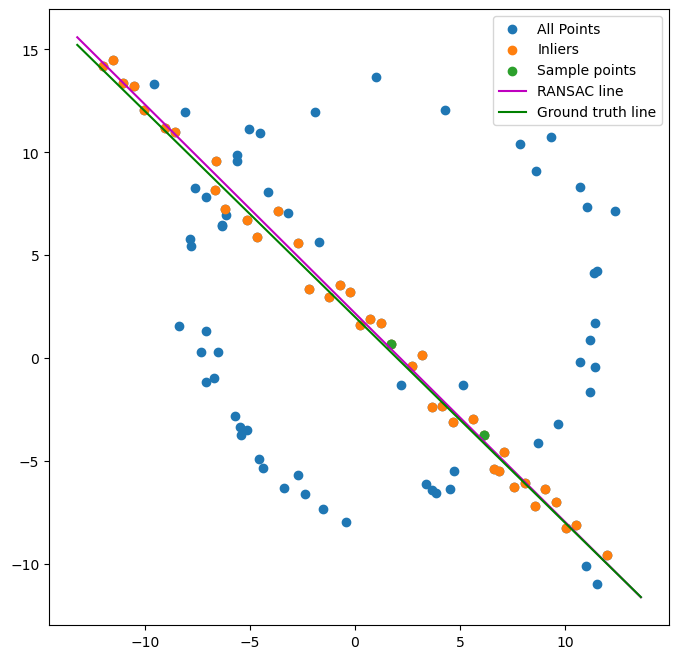

In [140]:
# Plot the line
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], label='All Points')
ax.scatter(X[best_line_inliers, 0], X[best_line_inliers, 1], label='Inliers')
ax.scatter(X[best_sample_points, 0], X[best_sample_points, 1], label='Sample points')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])

# Plot the RANSAC fitted line
y_ransac = (-best_fitted_line[0] * x_ + best_fitted_line[2]) / best_fitted_line[1]
plt.plot(x_, y_ransac, color='m', label='RANSAC line')

# Plot the ground truth line
y_gt = -1 * x_ + 2
plt.plot(x_, y_gt, color='g', label='Ground truth line')

plt.legend()
plt.show()

In [141]:
# Function to calculate the distance between 2 sample points
def distance(sample_1, sample_2):
    x1, y1 = sample_1
    x2, y2 = sample_2
    return ((x1-x2)**2 + (y1-y2)**2)**0.5
# Function to calculate the line parameters from 2 sample points
def circle_parameters(sample_1, sample_2, sample_3):
    x1, y1 = sample_1
    x2, y2 = sample_2
    x3, y3 = sample_3
    mx1, my1 = (x1 + x2) / 2, (y1 + y2) / 2
    mx2, my2 = (x1 + x3) / 2, (y1 + y3) / 2
    a1 = -(x2 - x1) / (y2 - y1)
    a2 = -(x3 - x1) / (y3 - y1)
    c1 = my1 - a1 * mx1
    c2 = my2 - a2 * mx2
    x0 = (c2 - c1) / (a1 - a2)
    y0 = a1 * x0 + c1
    r = distance((x0, y0), sample_1)
    return x0, y0, r
# Function to calculate TLS error 
def TLS_error_circle(parameters, *args):
    x0, y0, r = parameters
    indices, X = args
    error = np.sum((distance((x0, y0), (X[indices, 0], X[indices, 1])) - r)**2)
    return error
# Function to find consensus for circle
def consensus_circle(parameters, threshold, X):
    x0, y0, r = parameters
    errors = np.abs(distance((x0, y0), (X[:, 0], X[:, 1])) - r)
    inliers = np.where(errors < threshold)[0] # indices of the inliers 
    return inliers
# Function to circle fitting
def line_fit(indices, initial, X):
    circle = minimize(TLS_error_circle, initial, args=(indices, X), tol=1e-6)
    return circle

remaining_points = np.array([i for i in range(N) if i not in best_line_inliers])
X_remaining = X[remaining_points]
iterations = 100
sample_size = 3
threshold = 1.2
min_inlier_count = 0.4 * N

best_model_circle = None
best_fitting_circle = None
best_error = np.inf
best_circle_inliers = None
best_circle_sample_points = None

for i in range(iterations):
    sample_indices = np.random.choice(np.arange(len(X_remaining)), size=sample_size, replace=False)
    parameters = circle_parameters(*X_remaining[sample_indices])
    inliers = consensus_circle(parameters, threshold, X_remaining)
    print('Iteration: ', i, 'Inlier count: ', len(inliers))

    if len(inliers) > min_inlier_count:
        fitting_circle = line_fit(inliers, parameters, X_remaining)
        if fitting_circle.fun < best_error:
            best_error = fitting_circle.fun
            best_fitting_circle = fitting_circle.x
            best_model_circle = parameters
            best_circle_inliers = inliers
            best_circle_sample_points = sample_indices

circle_inliers = consensus_circle(best_fitting_circle, 1.2, X_remaining)
print(f'Best circle = {best_fitting_circle}, No of inliers = {len(circle_inliers)}, best error = {best_error}')

Iteration:  0 Inlier count:  27
Iteration:  1 Inlier count:  45
Iteration:  2 Inlier count:  26
Iteration:  3 Inlier count:  41
Iteration:  4 Inlier count:  8
Iteration:  5 Inlier count:  9
Iteration:  6 Inlier count:  46
Iteration:  7 Inlier count:  44
Iteration:  8 Inlier count:  16
Iteration:  9 Inlier count:  16
Iteration:  10 Inlier count:  10
Iteration:  11 Inlier count:  43
Iteration:  12 Inlier count:  8
Iteration:  13 Inlier count:  27
Iteration:  14 Inlier count:  44
Iteration:  15 Inlier count:  7
Iteration:  16 Inlier count:  18
Iteration:  17 Inlier count:  40
Iteration:  18 Inlier count:  16
Iteration:  19 Inlier count:  22
Iteration:  20 Inlier count:  44
Iteration:  21 Inlier count:  29
Iteration:  22 Inlier count:  10
Iteration:  23 Inlier count:  45
Iteration:  24 Inlier count:  27
Iteration:  25 Inlier count:  36
Iteration:  26 Inlier count:  49
Iteration:  27 Inlier count:  22
Iteration:  28 Inlier count:  21
Iteration:  29 Inlier count:  22
Iteration:  30 Inlier co

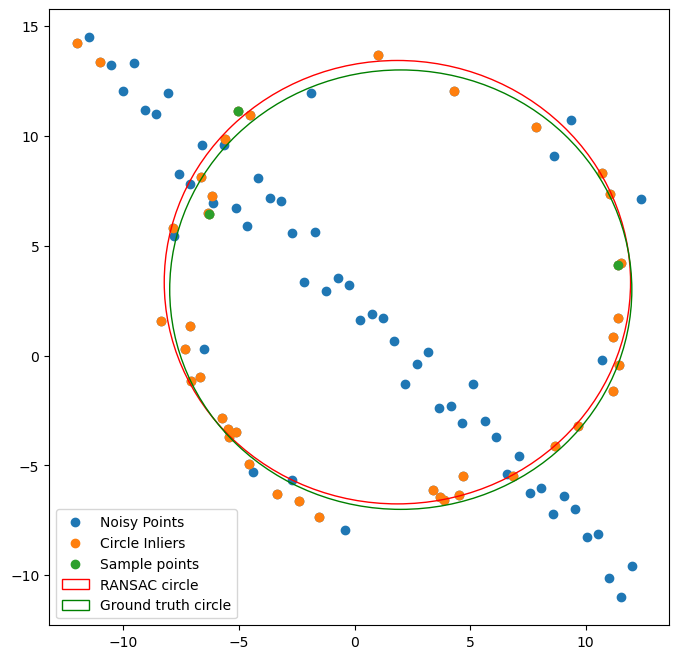

In [142]:
# Plot the circle
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], label='Noisy Points')
ax.scatter(X[best_circle_inliers, 0], X[best_circle_inliers, 1], label='Circle Inliers') 
ax.scatter(X[best_circle_sample_points, 0], X[best_circle_sample_points, 1], label='Sample points')
circle = plt.Circle((best_fitting_circle[0], best_fitting_circle[1]), best_fitting_circle[2], color='r', fill=False, label='RANSAC circle')
ax.add_patch(circle)
circle_gt = plt.Circle(circle_center, circle_radius, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
plt.legend()
plt.show()

## Question 3

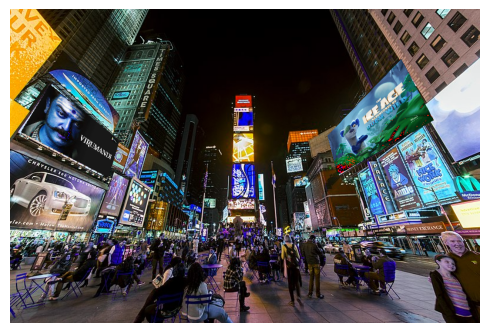

In [145]:
import cv2 as cv
import numpy as np

# Function to create overlay
def overlay_image(im_src, im_dst, pts_src, pts_dst):
    h = cv.getPerspectiveTransform(pts_src, pts_dst)
    transformed_image = cv.warpPerspective(im_src, h, (im_dst.shape[1], im_dst.shape[0]))
    b = (transformed_image[:,:,0] == 0) * im_dst[:,:,0]
    g = (transformed_image[:,:,1] == 0) * im_dst[:,:,1]
    r = (transformed_image[:,:,2] == 0) * im_dst[:,:,2]
    masked = np.dstack((b, g, r))
    overlayed = cv.add(masked, transformed_image)
    return overlayed

# Importing Images
ice_age = cv.imread('Images/ice-age.webp')
virumandi = cv.imread('Images/virumandi.jpg')
image = cv.imread('Images/times_square_night.jpg')
assert ice_age is not None
assert virumandi is not None
assert image is not None

# Function for getting co-ordinates by mouse click
def click_event(event, x, y, flags, params):
    if event == cv.EVENT_LBUTTONDOWN:
        print(x, ' ', y)

# Defining Points to find homography
iceAge_src = np.float32([[0, 0], [ice_age.shape[0], 0], [ice_age.shape[0], ice_age.shape[1]], [0, ice_age.shape[1]]])
ice_age_dst = np.float32([[540, 215], [593,160],[653,327],[573,344]])

virumandi_src = np.float32([[0, 0], [virumandi.shape[0], 0], [virumandi.shape[0], virumandi.shape[1]], [0, virumandi.shape[1]]])
virumandi_dst = np.float32([[68,128], [145,190],[90,330],[-35,295]])

final1 = overlay_image(ice_age, image, iceAge_src, ice_age_dst)
final2 = overlay_image(virumandi, final1, virumandi_src, virumandi_dst)

def show_images(images, size=10):
    fig = plt.figure(figsize=(size, size))
    num_images = len(images)

    for i, image_list in enumerate(images):
        for j, img in enumerate(image_list):
            ax = fig.add_subplot(num_images, len(image_list), i*len(image_list) + j + 1)
            ax.imshow(img, cmap='gray')  # Assuming images are grayscale, change cmap if needed
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Assuming image, ice_age, virumandi, and final2 are valid image arrays
show_images([[final2]], size=5)

## Question 4

In [146]:
# Extracting Co-ordinates of matching points using SIFT Operator
def points_extractor(image1,image2,verbose=False):
    sift = cv.SIFT_create()

    keypoints_1, descriptors_1 = sift.detectAndCompute(image1,None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(image2,None)

    # BFMatcher with default params
    bf = cv.BFMatcher()
    matches = bf.knnMatch(descriptors_1,descriptors_2, k=2)

    # Apply ratio test
    good = []

    for m,n in matches:
        if m.distance < .7*n.distance:
            good.append([m])

    matching_points = np.float32([[keypoints_1[mat[0].queryIdx].pt, keypoints_2[mat[0].trainIdx].pt]  for mat in good ])
    print("Number of Good Matches : ", len(good))

    if verbose:
        # Visualization
        image1_gray=cv.cvtColor(image1,cv.COLOR_BGR2GRAY)
        image2_gray=cv.cvtColor(image2,cv.COLOR_BGR2GRAY)
        f3 = cv.drawMatchesKnn(image1_gray,keypoints_1,image2_gray,keypoints_2,good,None)


        fig = plt.figure(figsize=(5, 5))
        plt.imshow(f3)
        plt.axis("off")
        plt.title("Visualizing Top Matches")
        plt.show()
    return matching_points

In [147]:
# Controlling Annoying Visulizations
verbose=False

# Reading All the Avialble Images
im1=cv.imread('Images/graffiti/img1.ppm',cv.IMREAD_COLOR)
im2=cv.imread('Images/graffiti/img2.ppm',cv.IMREAD_COLOR)
im3=cv.imread('Images/graffiti/img3.ppm',cv.IMREAD_COLOR)
im4=cv.imread('Images/graffiti/img4.ppm',cv.IMREAD_COLOR)
im5=cv.imread('Images/graffiti/img5.ppm',cv.IMREAD_COLOR)
im6=cv.imread('Images/graffiti/img6.ppm',cv.IMREAD_COLOR)
for image in [im1,im2,im3,im4,im5,im6]:
    assert image is not None

if verbose :
    show_images([[im1],[im2],[im3],[im4],[im5],[im6]])

Number of Good Matches :  1030
Number of Good Matches :  993
Number of Good Matches :  1170
Number of Good Matches :  934
Number of Good Matches :  30


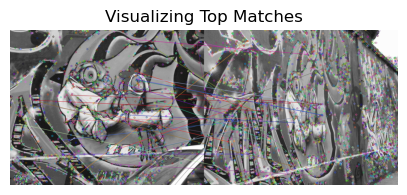

In [148]:
m_1_2=points_extractor(im1,im2)
m_2_3=points_extractor(im2,im3)
m_3_4=points_extractor(im3,im4)
m_4_5=points_extractor(im4,im5)
m_1_5=points_extractor(im1,im5,True)

In [152]:
from IPython.display import display, HTML

# # Transforming Image 1 to 5 using Ransac
# verbose=False
# threshold = [138,135,150,130]
# # Ransac Run
# r_1_2 = Ransac(m_1_2,threshold[0],'homo')
# r_2_3 = Ransac(m_2_3,threshold[1],'homo')
# r_3_4 = Ransac(m_3_4,threshold[2],'homo')
# r_4_5 = Ransac(m_4_5,threshold[3],'homo')

# _,h_1_2,_ = r_1_2.get_model()
# _,h_2_3,_ = r_2_3.get_model()
# _,h_3_4,_ = r_3_4.get_model()
# _,h_4_5,_ = r_4_5.get_model()



# if verbose:
#     print('RANSAC FITTING \n -------------\n')
#     print('image1 ----> image2\n',r_1_2,'\n')
#     print('image2 ----> image3\n',r_2_3,'\n')
#     print('image3 ----> image4\n',r_3_4,'\n')
#     print('image4 ----> image5\n',r_4_5,'\n')


# h_1_5=Homography(h_4_5.H@h_3_4.H@h_2_3.H@h_1_2.H)

# ransac_warped = cv.warpPerspective(im5 ,np.linalg.inv(h_1_5.H), (1400,650))
# ransac_warped[0:im1.shape[0], 0:im1.shape[1]] = im1

# # Original Transformation
# with open("./images/graffiti/H1to5p", "r") as txt_file:
#     f= txt_file.readlines()
# h=[[float(x) for x in line.split()] for line in f]

# r_t = Homography(h)


# original_warped = cv.warpPerspective(im5, np.linalg.inv(r_t.H), (1400,650))
# original_warped[0:im1.shape[0], 0:im1.shape[1]] = im1


# print('RANSAC Transformation :\n',h_1_5,'\n')
# print('Real Transformation :\n',r_t,'\n')
# show_images([[im1,'c',"Image 1"],[im3,'c',"Image 3"],[original_warped,'c',"Given Data"]],size=10)
# show_images([[ransac_warped,'c',"RANSAC Homography"]],size=10)

display(HTML(f'<img src="1.png" width="500">'))